# Computer Problem Set 3.1
## Monte Carlo approximation of the Greeks

### Question 1

#### (a)

We use theorical value :
$$
C_0 = e^{-rT}N\left(-d_{-}(X_0, \sigma^2T)\right), \Delta_0 = \frac{-e^{-rT}}{S_0\sqrt{\sigma^2T}}N'\left(-d_{-}(X_0, \sigma^2T)\right)
$$
with $X_0 = \frac{S_0}{Ke^{-rT}}$ and $d_{-}(x, v) = \frac{ln(x)}{\sqrt{v}} - \frac{1}{2}\sqrt{v}$.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# The function d_-(x, v):
def d_minus(x, v):
    sqrt_v = np.sqrt(v)
    return np.log(x) / sqrt_v - 0.5 * sqrt_v

# Calculation of theorical values
def theorical_values(r, sigma, S_0, T, K):
    '''
    We use the formula above to calculate the theorical value.
    '''
    ############ C_0
    X_0 = S_0 * np.exp(r * T)/ K
    sigma2T = sigma ** 2 * T
    minus_d_minus = -d_minus(X_0, sigma2T)
    C_0 = np.exp(-r * T) * norm.cdf(minus_d_minus)
    
    ############ Delta_0
    Delta_0 = -np.exp(-r * T) / S_0 / np.sqrt(sigma2T) * norm.pdf(minus_d_minus)
    return C_0, Delta_0

In [2]:
r = 0.02
sigma0 = 0.4
S_0 = 100
T = 0.9
K = 80
theorical_values(r, sigma0, S_0, T, K)

(0.3220459673863256, -0.00934908862823882)

#### (b)
The Monte Carlo approximation of $C_0$.

We know that the result only depends on $S_T$, and $S_T = S_0e^{(r-\frac{\sigma^2}{2})T + \sigma B_T}$.

We are gonna simulate $B_T$, then $S_T$ and then determinate $C_0^M$.

In [3]:
def MC_C(r, sigma, S_0, T, K, M):
    '''
    We first simulate Brownian at T, then S_T.
    Then we determinate C_0 by Monte Carlo Method
    '''
    brownian_T = np.random.normal(loc=0, scale=np.sqrt(T), size=M)
    S_T = S_0 * np.exp((r - sigma * sigma / 2) * T + sigma * brownian_T)

    ############ C_0^M
    C_0 = np.exp(-r * T) * np.mean(S_T <= K)
    return C_0

#### (c)
We use K = 80 + i for $i = 0, \dots, 40$, for various samples sizes.

In [4]:
theorical_C = []
C_100 = []
C_1000 = []
C_10000 = []

# We variate K from 80 to 121
for K in range(80, 121):
    theorical_C.append(theorical_values(r, sigma0, S_0, T, K)[0])
    C_100.append(MC_C(r, sigma0, S_0, T, K, 100))
    C_1000.append(MC_C(r, sigma0, S_0, T, K, 1000))
    C_10000.append(MC_C(r, sigma0, S_0, T, K, 10000))

Text(0, 0.5, 'C_0')

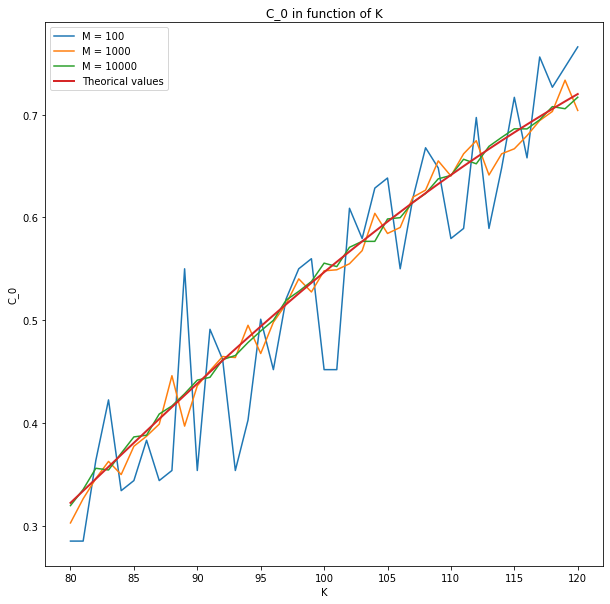

In [5]:
# Plot
plt.figure(figsize=(10, 10))
plt.plot(list(range(80, 121)), C_100, label="M = 100")
plt.plot(list(range(80, 121)), C_1000, label="M = 1000")
plt.plot(list(range(80, 121)), C_10000, label="M = 10000")
plt.plot(list(range(80, 121)), theorical_C, label="Theorical values", linewidth=2)
plt.title("C_0 in function of K")
plt.legend(loc="best")
plt.xlabel("K")
plt.ylabel("C_0")

We observe that 
 * If M is smaller, the result is less precise. This is the default error from the Monte Carlo method.
 * $C_0$ is greater when $K$ is greater : it's normal while we have more chance to have $1_{\{S_T\le K\}}$

### Question 2

#### (a)
Approximation of $\Delta_0$ while
$$\Delta_0^{M, \varepsilon} = \frac{C^M_0(S_0 + \varepsilon) - C^M_0(S_0 - \varepsilon)}{2\varepsilon}$$

In [6]:
def MC_Delta(r, sigma, S_0, T, K, epsilon, M):
    '''
    We first simulate Brownian at T, then S_T_plus_eps and S_T_minus_eps.
    Then we determinate Delta_0 by Monte Carlo Method
    '''
    brownian_T = np.random.normal(loc=0, scale=np.sqrt(T), size=M)
    S_T_plus_eps = (S_0 + epsilon) * np.exp((r - sigma * sigma / 2) * T + sigma * brownian_T)
    S_T_minus_eps = (S_0 - epsilon) * np.exp((r - sigma * sigma / 2) * T + sigma * brownian_T)
    
    ############ C_0^M
    C_0_plus_eps = np.exp(-r * T) * (S_T_plus_eps <= K)
    C_0_minus_eps = np.exp(-r * T) * (S_T_minus_eps <= K)
    
    ############ Delta_0^{M, eps}
    Delta_MC = (C_0_plus_eps - C_0_minus_eps) / 2 / epsilon
    estimation = np.mean(Delta_MC)
    IC_half_length = 1.96 * np.sqrt(np.var(Delta_MC) / M)

    return estimation, [estimation - IC_half_length, estimation + IC_half_length]

#### (b)
Comparison according to the variance. We use $\varepsilon \in \{0.01, 0.02\dots, 0.3\}$ with a step $= 0.01$ and $M \in \{100, 1000, 10000\}$.

In [9]:
def test_epsilon(r, sigma0, S_0, T, K):
    theorical_Delta = []
    Delta_100 = []
    Delta_1000 = []
    Delta_10000 = []
    
    K = 80
    # We variate M in {100, 1000, 10000}
    def diff(two_elements_list):
        return abs(two_elements_list[0] - two_elements_list[1]) / 2.
    for epsilon in np.linspace(0.01, 0.3, num=30):
        Delta_100.append(diff(MC_Delta(r, sigma0, S_0, T, K, epsilon, 100)[1]))
        Delta_1000.append(diff(MC_Delta(r, sigma0, S_0, T, K, epsilon, 1000)[1]))
        Delta_10000.append(diff(MC_Delta(r, sigma0, S_0, T, K, epsilon, 10000)[1]))

    # Plot
    plt.figure(figsize=(6, 6))
    x = np.linspace(0.01, 0.3, num=30)
    plt.plot(x, Delta_100, label="M = 100")
    plt.plot(x, Delta_1000, label="M = 1000")
    plt.plot(x, Delta_10000, label="M = 10000")
    #plt.plot(list(range(80, 121)), theorical_Delta, label="Theorical values", linewidth=2)
    plt.title("Delta_0 in function of epsilon with different M")
    plt.legend(loc="best")
    plt.xlabel("epsilon")
    plt.ylabel("Delta_0")

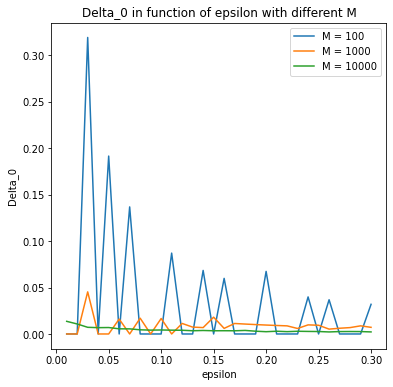

In [10]:
test_epsilon(r, sigma0, S_0, T, 80)

We observe that :
 * while $\varepsilon$ is small (0.01), we have almost every difference of $C^M_0(S_0 + \varepsilon)$ and $C^M_0(S_0 - \varepsilon) = 0$ for all $K$. However, if there's one of the samples who admits a difference, then the fact that the difference is divided by $2\varepsilon$ makes it much greater than the theorical value. That's why we get a greater variance when the variance is not $0$.
 * while $\varepsilon$ is great (0.3), the derivative is pretty good for greater $M$. But we are not sure that it could work before this test since the finite-difference approximation should have be worse in this case.

### Question 3

#### (a)
We use the formula:
$$
\Delta_0 = e^{-rT}\mathbb{E}\left[ 1_{\{S_T \le K\} } \frac{B_T}{S_0\sigma T} \right]
$$

In [9]:
def MC_Delta_importance_sampling(r, sigma, S_0, T, K, M):
    '''
    We first simulate Brownian at T, then S_T.
    Then we determinate Delta_0 by Monte Carlo Method with Importance sampling.
    '''
    brownian_T = np.random.normal(loc=0, scale=np.sqrt(T), size=M)
    S_T = S_0 * np.exp((r - sigma * sigma / 2) * T + sigma * brownian_T)
    
    ############ Delta_0
    Delta_0 = np.exp(-r * T) * np.mean((S_T <= K) * brownian_T / (S_0 * sigma * T))
    IC_half_length = 1.96 * np.exp(-r * T) * np.sqrt(np.var((S_T <= K) * brownian_T / (S_0 * sigma * T)) / M)
    return Delta_0, [Delta_0 - IC_half_length, Delta_0 + IC_half_length]

#### (b)

Text(0, 0.5, 'Delta_0')

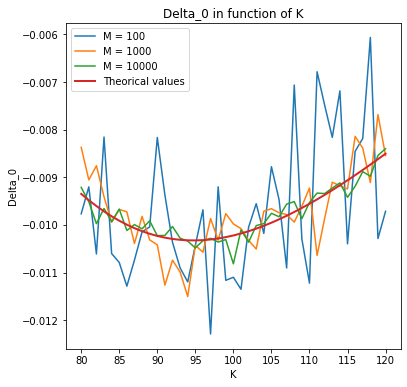

In [10]:
# We variate K from 80 to 121
theorical_Delta = []
Delta_100 = []
Delta_1000 = []
Delta_10000 = []
for K in range(80, 121):
    theorical_Delta.append(theorical_values(r, sigma0, S_0, T, K)[1])
    Delta_100.append(MC_Delta_importance_sampling(r, sigma0, S_0, T, K, 100)[0])
    Delta_1000.append(MC_Delta_importance_sampling(r, sigma0, S_0, T, K, 1000)[0])
    Delta_10000.append(MC_Delta_importance_sampling(r, sigma0, S_0, T, K, 10000)[0])

# Plot
plt.figure(figsize=(6, 6))
plt.plot(list(range(80, 121)), Delta_100, label="M = 100")
plt.plot(list(range(80, 121)), Delta_1000, label="M = 1000")
plt.plot(list(range(80, 121)), Delta_10000, label="M = 10000")
plt.plot(list(range(80, 121)), theorical_Delta, label="Theorical values", linewidth=2)
plt.title("Delta_0 in function of K")
plt.legend(loc="best")
plt.xlabel("K")
plt.ylabel("Delta_0")

We have a very good approximation of $\Delta_0$

Comparison with $\Delta_0^{M, \varepsilon}$ :

We use $M = 10000, \varepsilon = 0.1$

In [11]:
M = 10000
epsilon = 0.1
confidence_interval_lengths = []
confidence_interval_lengths_IS = []
# K from 80 to 120
for K in range(80, 121):
    conf_lengs = MC_Delta(r, sigma0, S_0, T, K, epsilon, M)[1]
    confidence_interval_lengths.append(conf_lengs[1] - conf_lengs[0])
    
    conf_lengs_IS = MC_Delta_importance_sampling(r, sigma0, S_0, T, K, M)[1]
    confidence_interval_lengths_IS.append(conf_lengs_IS[1] - conf_lengs_IS[0])

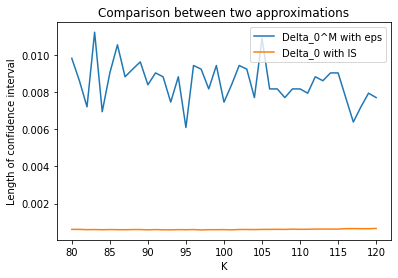

In [12]:
plt.plot(list(range(80, 121)), confidence_interval_lengths, label="Delta_0^M with eps")
plt.plot(list(range(80, 121)), confidence_interval_lengths_IS, label="Delta_0 with IS")
plt.title("Comparison between two approximations")
plt.xlabel("K")
plt.ylabel("Length of confidence interval")
plt.legend(loc="best")

In [13]:
print(np.mean(np.array(confidence_interval_lengths) / np.array(confidence_interval_lengths_IS)))

14.011951034814404


The importance sampling method has a much better performance than the common approach. The length of the confidence interval is 14 times smaller in average.